# Lesson 1

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
help(untar_data)

In [ ]:
path = untar_data(URLs.PETS);path

In [ ]:
path.ls()

In [ ]:
path_ann = path/'annotations'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

In [ ]:
np.random.seed(42)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat,
                                  ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes), data.c

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,7))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.recorder.plot()

# Lesson 2
## Data Cleaning and production , SGD from scratch

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
folder = 'monkey'
file = 'monkey.txt'

In [ ]:
folder = 'langur'
file='langur.txt'

In [ ]:
folder = 'baboon'
file='baboon.txt'

In [ ]:
path = Path('data/monkey_class')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file,dest, max_pics=200)

In [ ]:
path.ls()

In [ ]:
classes = ['baboon', 'langur','monkey']

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [ ]:
np.random.seed(42)
data= ImageDataBunch.from_folder(path, train=" ", valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics= error_rate)

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5),dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-05,1e-03))

In [ ]:
learn.save('stage-2')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch())

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

In [ ]:
learn.export()

In [ ]:
import fastai
fastai.basics.defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/r'C:\Users\jinsel\Desktop'/'testing'/'index.jpg')
img

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

# Lesson 3
## Data blocks, Multi-label classification; Segmentation

### 1. Planet Classification

In [ ]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *
import fastai

In [ ]:
#! {sys.executable} -m pip install kaggle --upgrade

In [ ]:
#! mkdir %userprofile%\.kaggle
#! move kaggle.json %userprofile%\.kaggle

In [ ]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path.ls()

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

In [ ]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [ ]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [ ]:
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
data= pd.read_csv(path/'train_v2.csv')
data.head(5)

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2/train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
arch = models.resnet34

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr =0.01

In [ ]:
learn.fit_one_cycle(5,slice(lr))

In [ ]:
learn.save('stage-1-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

In [ ]:
 learn.save('stage-2-rn34')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data=data
data.train_ds[0][0].shape

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2
learn.fit_one_cycle(5,slice(lr))

In [ ]:
learn.save('stage-1-256-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn34')

### 2. Segmentation Detection with CamVid

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/jinsel/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/jinsel/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/images/0001TP_006750.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/jinsel/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/jinsel/.fastai/data/camvid/labels/0001TP_006750_P.png')]

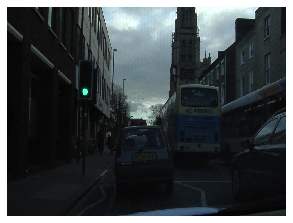

In [8]:
img_f =fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn(img_f)

WindowsPath('C:/Users/jinsel/.fastai/data/camvid/labels/0001TP_006690_P.png')

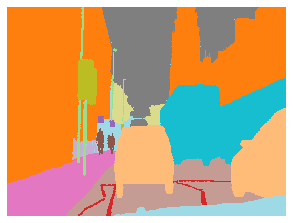

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
valids = np.loadtxt(path/'valid.txt', dtype=str); valids

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

In [15]:
size=src_size//3
free = gpu_mem_get_free_no_cache()
if free > 8200: 
    bs=8
else:
    bs=4
print(f"Using bs={bs}, have {free}MB of GPU RAM free")

Using bs=4, have 4018MB of GPU RAM free


In [18]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [34]:
data = (src.transform(get_transforms(), size=size,tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

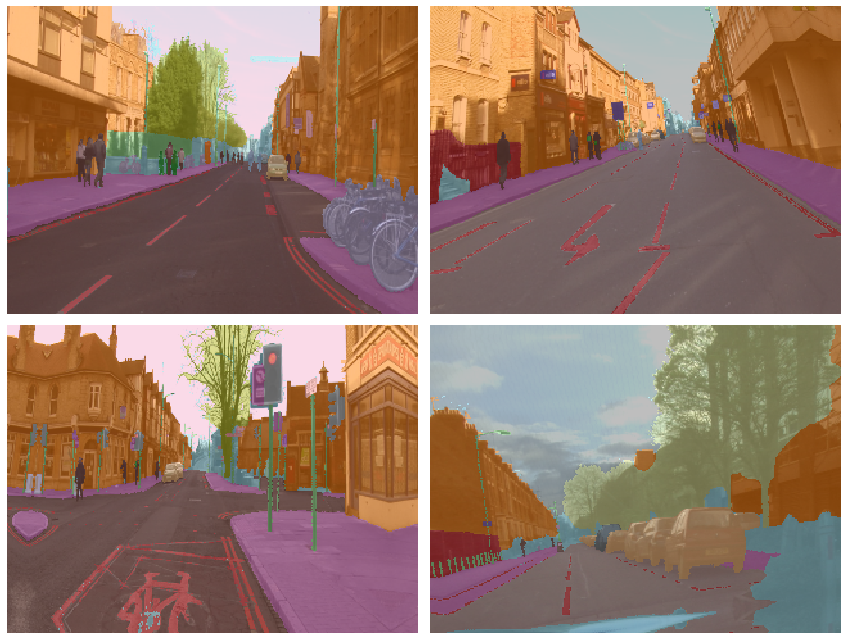

In [35]:
data.show_batch(2, figsize=(12,9))

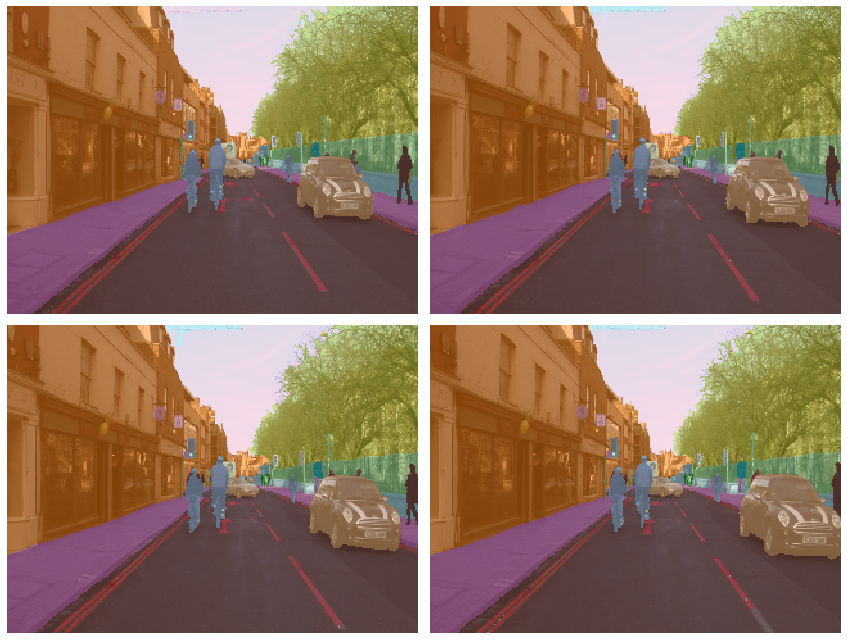

In [36]:
data.show_batch(2, figsize=(12,9), ds_type=DatasetType.Valid)

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


In [22]:
print(name2id)

{'Animal': 0, 'Archway': 1, 'Bicyclist': 2, 'Bridge': 3, 'Building': 4, 'Car': 5, 'CartLuggagePram': 6, 'Child': 7, 'Column_Pole': 8, 'Fence': 9, 'LaneMkgsDriv': 10, 'LaneMkgsNonDriv': 11, 'Misc_Text': 12, 'MotorcycleScooter': 13, 'OtherMoving': 14, 'ParkingBlock': 15, 'Pedestrian': 16, 'Road': 17, 'RoadShoulder': 18, 'Sidewalk': 19, 'SignSymbol': 20, 'Sky': 21, 'SUVPickupTruck': 22, 'TrafficCone': 23, 'TrafficLight': 24, 'Train': 25, 'Tree': 26, 'Truck_Bus': 27, 'Tunnel': 28, 'VegetationMisc': 29, 'Void': 30, 'Wall': 31}


In [23]:
metrics = acc_camvid

In [46]:
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


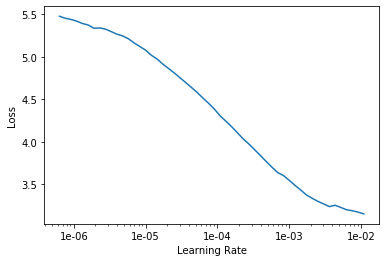

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
lr=1e-04

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.195394,1.653925,0.586901,03:20
1,1.300266,1.029908,0.756483,03:14
2,0.975272,0.872514,0.804360,03:16
3,0.839700,0.731487,0.816961,03:17
4,0.733573,0.683686,0.826495,03:43
5,0.669146,0.584600,0.848151,03:34
6,0.619788,0.523185,0.858414,03:26
7,0.566432,0.538757,0.851828,03:33
8,0.526533,0.490600,0.863897,03:16
9,0.466527,0.400092,0.880960,03:16


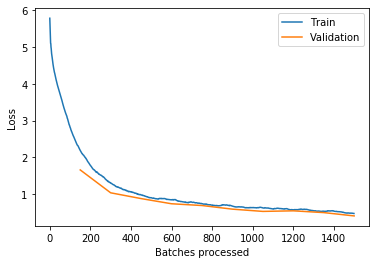

In [50]:
learn.recorder.plot_losses()

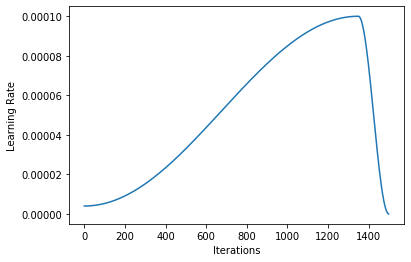

In [51]:
learn.recorder.plot_lr()

In [53]:
learn.save('stage-1-segment')

In [55]:
learn.load('stage-1-segment')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegmentationLabelList
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: C:\Users\jinsel\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegmentationLabelList
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: C:\Users\jinsel\.fastai\data\camvid\images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

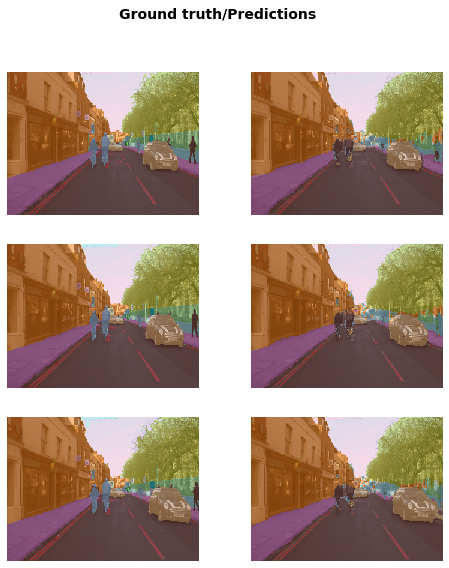

In [56]:
learn.show_results(rows=3, figsize=(8,9))

In [57]:
learn.unfreeze()

In [58]:
lrs = slice(lr/400,lr/4)

In [59]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.452951,0.402197,0.878631,03:24
1,0.446898,0.409335,0.876493,03:34
2,0.432234,0.398954,0.879111,03:28
3,0.435272,0.399500,0.880042,03:27
4,0.431054,0.396304,0.882175,03:30
5,0.419567,0.399124,0.880823,03:23
6,0.429655,0.396434,0.886064,03:35
7,0.419036,0.400838,0.882381,03:32
8,0.400261,0.367991,0.895358,03:11
9,0.396985,0.367867,0.895239,02:59


In [62]:
learn.save('stage-2-segment')

In [35]:
learn.purge()
import gc; gc.collect()
torch.cuda.empty_cache()

this object has been destroyed


In [36]:
size=src_size
free = gpu_mem_get_free_no_cache()
if free >8200:
    bs=3
else:
    bs=1
print(f"using {bs}, have {free}MB of GPU RAM free")

using 1, have 3616MB of GPU RAM free


In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.load('stage-2-segment');

In [42]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 2.91 GiB already allocated; 627.20 KiB free; 46.15 MiB cached)

In [ ]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)